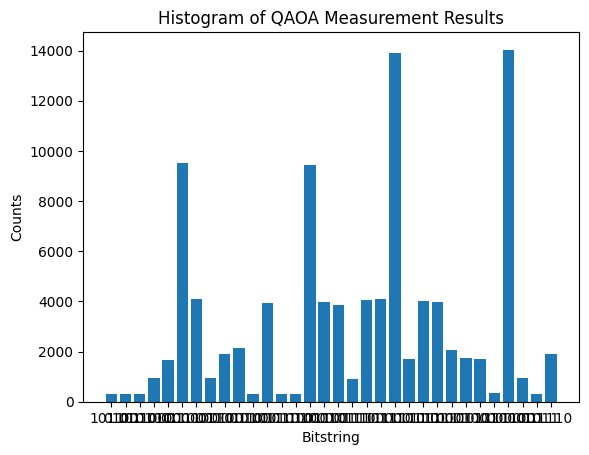

Bitstring: 00000, Count: 14033, Max Cut Value: 0
Bitstring: 11111, Count: 13892, Max Cut Value: 0
Bitstring: 01100, Count: 9516, Max Cut Value: 5
Bitstring: 10011, Count: 9424, Max Cut Value: 5
Bitstring: 10000, Count: 4096, Max Cut Value: 2
Maximum cut: 5
Best partition: Set A: [2], Set B: [0, 1, 3, 4]
Cut edges: [(1, 2), (2, 3)]


{(0, 1): Text(0.6905319090629924, -0.3272208025425767, '1'),
 (0, 4): Text(0.5843800210519075, 0.4920460584872105, '1'),
 (1, 2): Text(-0.1751077087150963, -0.6064739265290973, '1'),
 (2, 3): Text(-0.7749047456709742, -0.10054275241451771, '4'),
 (3, 4): Text(-0.32489824910683174, 0.5421766641295515, '1')}

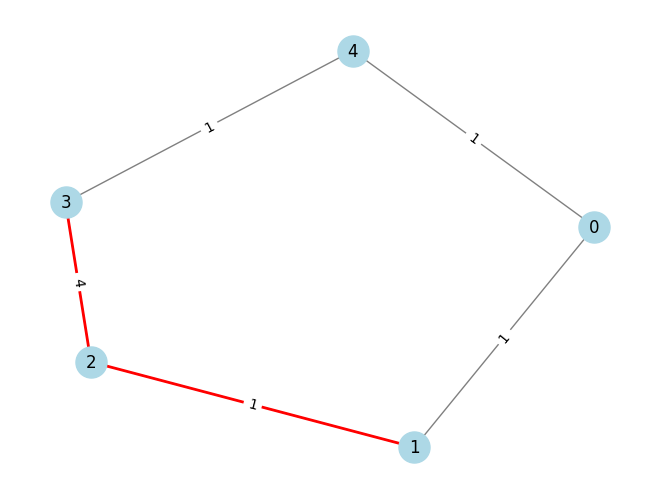

In [106]:
import networkx as nx
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
# Step 1: Define the Graph
import networkx as nx
from qiskit.visualization import plot_histogram
from qiskit_optimization import QuadraticProgram

import networkx as nx
from qiskit_optimization import QuadraticProgram

def graph_to_qubo(graph, isolated_penalty=10):
    """
    Convert an undirected weighted graph into a QUBO formulation of the Max-Cut problem.
    
    Each node i is represented by a binary variable x_i.
    For each edge (i, j) with weight w, the contribution to the objective is:
        -w*(x_i + x_j - 2*x_i*x_j)
    which is -w if the edge is cut (i.e. x_i != x_j) and 0 if not.
    Minimizing the objective is equivalent to maximizing the total weight of the cut edges.
    
    Additionally, for nodes with no edges (isolated nodes), a penalty is added
    to discourage them from taking the value 1 unless that isolated node is alone 
    in its partition (i.e. if there is only one isolated node, no penalty is applied).
    
    Parameters:
        graph (nx.Graph): A NetworkX graph with edge weights stored under the key 'weight'.
        isolated_penalty (float): The penalty added to isolated nodes.
    
    Returns:
        qp (QuadraticProgram): The QUBO formulated as a QuadraticProgram.
    """
    qp = QuadraticProgram()

    # Add a binary variable for each node in the graph.
    for node in graph.nodes():
        qp.binary_var(name=str(node))
    
    # Initialize dictionaries for the linear and quadratic coefficients.
    linear_coeffs = {str(node): 0 for node in graph.nodes()}
    quadratic_coeffs = {}
    
    # Process each edge to add its contribution.
    # For edge (i, j) with weight w:
    #   - Add -w to each of the nodes (linear terms)
    #   - Add 2*w as the quadratic coefficient for x_i * x_j
    for i, j, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        linear_coeffs[str(i)] += -weight
        linear_coeffs[str(j)] += -weight
        
        key = tuple(sorted((str(i), str(j))))
        quadratic_coeffs[key] = quadratic_coeffs.get(key, 0) + 2 * weight

    # Identify isolated nodes (nodes with no edges).
    isolated_nodes = [node for node in graph.nodes() if graph.degree(node) == 0]
    
    # Only add an isolation penalty if there is more than one isolated node.
    # This implies that if an isolated node is by itself (the only isolated node)
    # then we do not add the penalty.
    if len(isolated_nodes) > 1:
        for node in isolated_nodes:
            linear_coeffs[str(node)] += isolated_penalty

    # Build the QUBO objective.
    qp.minimize(linear=linear_coeffs, quadratic=quadratic_coeffs)
    qp.objective.constant = 0

    return qp




# Create a square graph with weights
square_graph = nx.Graph()
# square_graph.add_weighted_edges_from([
#     (0, 1, 1),  # edge from 0 to 1 with weight 3
#     (1, 2, 1),  # edge from 1 to 2 with weight 4
#     (2, 3, 1),  # edge from 2 to 3 with weight 5
#     (3, 0, 1)
# ])

square_graph.add_weighted_edges_from([
    (0, 1, 1),  # edge from 0 to 1 with weight 3
    (1, 2, 1),  # edge from 1 to 2 with weight 4
    (2, 3, 4),  # edge from 2 to 3 with weight 5
    (3, 4, 1),
    (4, 0, 1)
])

# square_graph.add_weighted_edges_from([
#     (0, 1, 1),  # edge from 0 to 1 with weight 3
#     (1, 2, 1),  # edge from 1 to 2 with weight 4
#     (2, 3, -1),  # edge from 2 to 3 with weight 5
#     (3, 4, 4),   # edge from 3 to 0 with weight 6
#     (4, 5, 4),   # edge from 3 to 0 with weight 6
#     (5, 0, -5),   # edge from 3 to 0 with weight 6
#     (1, 3, 4)   # edge from 3 to 0 with weight 6
# ])

# Step 2: Convert Graph to QUBO using Maxcut class
# maxcut = Maxcut(square_graph)
# qubo = maxcut.to_quadratic_program ()
qubo = graph_to_qubo(square_graph,0)


# Step 3: Convert QUBO to Ising Hamiltonian
ising, ising_offset = qubo.to_ising ()

# Step 4: Create QAOA Circuit
qaoa_reps = 2
qaoa_ansatz = QAOAAnsatz(cost_operator=ising, reps=qaoa_reps, name='qaoa')
qaoa_ansatz.measure_active ()

# Step 5: Assign Parameters
betas = np.random.uniform(0, np.pi, qaoa_reps)
gammas = np.random.uniform(0, 2*np.pi, qaoa_reps)
parameter_values = [*betas, *gammas]
qaoa_with_parameters = qaoa_ansatz.assign_parameters(dict(zip(qaoa_ansatz.parameters, parameter_values)))

# Step 6: Execute on Simulator
aer_simulator = AerSimulator ()
compiled_qaoa = transpile(qaoa_with_parameters, aer_simulator)
result = aer_simulator.run(compiled_qaoa, shots=10**5).result ()
counts = result.get_counts()

#print(counts)

bitstrings = list(counts.keys())
frequencies = list(counts.values())

# Create the histogram
plt.figure()
plt.bar(bitstrings, frequencies)
plt.xlabel('Bitstring')
plt.ylabel('Counts')
plt.title('Histogram of QAOA Measurement Results')
plt.show()

def compute_cut_value(bitstring, graph):
    """
    Compute the max cut value for a given bitstring and graph.
    
    Parameters:
        bitstring (str): A binary string representing a partition of the nodes.
        graph (nx.Graph): A NetworkX graph with edge weights stored under 'weight'.
    
    Returns:
        cut_value (float): The total weight of the cut.
    """
    cut_value = 0
    # Assuming the bitstring positions correspond to nodes in sorted order.
    # For each edge, if the corresponding bits are different, add its weight.
    for i, j, data in graph.edges(data=True):
        # Convert node labels to integers for indexing, if needed.
        # This assumes node labels 0, 1, ..., n-1 and bitstring index order matches.
        if bitstring[i] != bitstring[j]:
            cut_value += data.get('weight', 1)
    return cut_value

# Example usage given your existing code for the top 5 bitstrings:
top_5 = sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the top 5 most common bitstrings with their counts and max cut value.
for bitstring, count in top_5:
    value = compute_cut_value(bitstring, square_graph)
    print(f"Bitstring: {bitstring}, Count: {count}, Max Cut Value: {value}")


# Step 7: Discard 0000 and 1111 as these are Not Cuts -> [][0, 1, 2, 3] and [1, 2, 3, 4][]
def is_trivial_solution(binary_string):
    """
    Check if the solution is trivial (either all 0's or all 1's).
    """
    return binary_string == '0' * len(binary_string) or binary_string == '1' * len(binary_string)

# Step 8: Filter out trivial solutions (0000, 1111)
filtered_counts = {binary_string: count for binary_string, count in counts.items() if not is_trivial_solution(binary_string)}

# Step 9: Calculate the Max-Cut and Max Number of Cuts
def calculate_max_cut(graph):
    """
    Calculate the maximum number of cuts for a given graph.
    """
    # Define all possible partitions
    max_cuts = 0
    best_partition = None
    max_sum = 0
    # Loop over all possible partitions of the graph into two sets
    num_nodes = len(graph.nodes)
    for i in range(1, 1 << num_nodes):
        set_a = [node for node in range(num_nodes) if (i & (1 << node)) > 0 ]
        set_b = [node for node in range(num_nodes) if (i & (1 << node)) == 0]
        cur_sum = 0
        # Calculate cut edges between set A and set B
        cut_edges = []
        for edge in graph.edges:
            if (edge[0] in set_a and edge[1] in set_b) or (edge[0] in set_b and edge[1] in set_a):
                cut_edges.append(edge)
                cur_sum+=graph[edge[0]][edge[1]].get('weight', None)
        
        # Check if this partition has more cuts
        #print(set_a,set_b)
        
        if cur_sum > max_sum and len(cut_edges) < num_nodes and are_nodes_connected(graph, set_a) and are_nodes_connected(graph, set_b):
            max_cuts = len(cut_edges)
            best_partition = (set_a, set_b, cut_edges)
            max_sum=cur_sum

    return max_sum, best_partition

def are_nodes_connected(graph, nodes):
    # If there are 0 or 1 nodes, it's trivially connected.
    if len(nodes) < 2:
        return True
    
    # Create the subgraph induced by these nodes.
    subgraph = graph.subgraph(nodes)
    
    # Check if the subgraph is connected.
    return nx.is_connected(subgraph)


# Step 10: Calculate the maximum cut for the graph
max_cuts, best_partition = calculate_max_cut(square_graph)

# Step 11: Output the results
print(f"Maximum cut: {max_cuts}")
print(f"Best partition: Set A: {best_partition[0]}, Set B: {best_partition[1]}")
print(f"Cut edges: {best_partition[2]}")

pos = nx.spring_layout(square_graph)

# Draw the nodes and edges
nx.draw(square_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

# Highlight the cut edges from the best partition
cut_edges = best_partition[2]
nx.draw_networkx_edges(square_graph, pos, edgelist=cut_edges, edge_color='red', width=2)

# Get the edge weights as labels
edge_labels = nx.get_edge_attributes(square_graph, 'weight')

# Draw the edge labels on the graph
nx.draw_networkx_edge_labels(square_graph, pos, edge_labels=edge_labels)


#plt.title("Graph with Highlighted Cut Edges")
#plt.show()


We successfully implemented a classical algorithm for the max cut problem that we used to check for correctness in the quantum approach. We plotted the results of the QAOA on a histogram after 100000 shots. The results tended towards the correct answer though would often lead to inelligeble partitions. In order to counteract this we implemented an isolation penalty that would apply a negative weighting to nodes with no edges. This addition decreased the number of inelligeble cuts but did not otherwise increase the accuracy of the result of the model.